<a href="https://colab.research.google.com/github/Cepera90/test/blob/main/test_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Open inc_points_c
TC = pd.read_csv("/content/drive/MyDrive/test/inc_points_c.csv")
TC = TC.drop(['Unnamed: 0'], axis=1)

In [ ]:
# See median values for drivers and passangers
TC.groupby('TrackOrigin').median()

,Unnamed: 0,IncomingTrackId,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
TrackOrigin,,,,,,,,,,,,
OriginalDriver,1383425.0,20681420.0,8.780098,53.214530,45.930267,107091.0,0.0,0.0,1.571309e+09,0.000000,-0.104874,-0.294083
Passanger,3310451.0,20800891.0,31.359722,51.774608,55.232452,110196.0,0.0,0.0,1.571386e+09,-0.002433,0.000000,-0.189388
Taxi,3233483.0,20713602.0,18.775861,55.717843,37.575511,155900.0,0.0,0.0,1.571312e+09,0.000000,0.000000,0.052414


We see what median passanger user speed more when drivers speed (I think because professional drivers have strict speed limit)

In [ ]:
# See mean values for drivers and passangers
TC.groupby('TrackOrigin').mean()

,Unnamed: 0,IncomingTrackId,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal,MidOverSpeed,HiOverSpeed
TrackOrigin,,,,,,,,,,,,,,
OriginalDriver,1.383425e+06,2.070059e+07,24.503922,34.726617,67.394502,127853.709936,0.045015,0.078361,1.571310e+09,-0.01030,-0.146879,-0.248071,4.768319,0.460334
Passanger,3.303812e+06,2.069142e+07,37.948386,21.225763,84.263927,115249.570732,0.069823,0.182956,1.571297e+09,0.01037,0.028603,-0.154312,10.552048,1.185344
Taxi,3.231599e+06,2.065376e+07,33.141940,51.783496,34.897831,155451.098302,0.264315,0.392949,1.571291e+09,0.03827,-0.044998,0.102176,8.952944,1.044906


We see what mean passanger user speed more when drivers speed. Taxi mean acceleration and deceleration more then OriginalDriver and Taxi.

In [3]:
# Open rich_tracks_2
RT = pd.read_csv("/content/drive/MyDrive/test/rich_tracks_2.csv")

In [ ]:
# See standart deviation values for drivers and passangers
RT.groupby('TrackOrigin').std()

,Id,IncomingTrackId,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,OriginChanged,DistanceGPS,...,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,RatingCornering,VehicleId,BeaconId,DeviationRatio,DeviationMeters
TrackOrigin,,,,,,,,,,,,,,,,,,,,,
OriginalDriver,4801.492524,7.024230e+04,400.357699,28.220975,2.439093,3.154929,1.139604,2.468450,0.0,20.389829,...,1.515978,115.376788,220.519050,184.963118,297.982948,0.701323,NaN,NaN,0.000675,21.208906
Passanger,259711.240231,1.585408e+06,375.529387,38.344564,2.741259,3.029253,1.110365,7.581252,0.0,38.122624,...,9.396443,205.534600,339.757433,561.066446,435.932303,1.097489,NaN,NaN,0.000609,27.464519
Taxi,270605.859722,1.623501e+06,224.925853,29.744323,1.398211,2.161288,1.166092,2.183238,0.0,33.480420,...,1.296748,261.604315,195.238016,540.821350,295.079220,NaN,NaN,NaN,0.000000,26.437740


We see what standart deviation of Duration and PhoneUsage in passanger track data more whan in drivers track data, so we can add duration to inc_point dataframe.

In [4]:
# Create DF with rich_tracks_2 data
ID_t = pd.DataFrame({'IncomingTrackId':RT['IncomingTrackId'],'TrackOrigin':RT['TrackOrigin'],
                     'PhoneUsage':RT['PhoneUsage'],'Duration':RT['Duration']})

In [5]:
# Create DB with track summary
TrackDB = TC.groupby('IncomingTrackId')[['Speed','Acceleration','Deceleration','AccelerationXOriginal',
                                         'AccelerationYOriginal','AccelerationZOriginal','Latitude', 'Longitude', 'Height']].describe()

In [6]:
# Flatten MultiIndex columns
index = TrackDB.columns = [f'{i}|{j}' if j != '' else f'{i}' for i,j in TrackDB.columns]
TrackDB = TrackDB.reindex(index, axis=1)

In [7]:
# Merge ID_t with TrackDB
TrackDB = TrackDB.merge(ID_t, on='IncomingTrackId')

In [8]:
# Add columns with difference max and min values
TrackDB_min = ['Speed|min','Acceleration|min','Deceleration|min','AccelerationXOriginal|min',
               'AccelerationYOriginal|min','AccelerationZOriginal|min','Latitude|min','Longitude|min','Height|min']

TrackDB_max = ['Speed|max','Acceleration|max','Deceleration|max','AccelerationXOriginal|max',
               'AccelerationYOriginal|max','AccelerationZOriginal|max','Latitude|max','Longitude|max','Height|max']

TrackDB_diff = ['Speed|diff','Acceleration|diff','Deceleration|diff','AccelerationXOriginal|diff',
                'AccelerationYOriginal|diff','AccelerationZOriginal|diff','Latitude|diff','Longitude|diff','Height|diff']

TrackDB[TrackDB_diff] = TrackDB[TrackDB_max].values - TrackDB[TrackDB_min].values

In [9]:
# Delete IncomingTrackId column
TrackDB = TrackDB.drop(['IncomingTrackId','Latitude|count', 'Latitude|mean', 'Latitude|std', 'Latitude|min', 
                        'Latitude|25%', 'Latitude|50%', 'Latitude|75%', 'Latitude|max',
                        'Longitude|count', 'Longitude|mean', 'Longitude|std', 'Longitude|min',
                        'Longitude|25%', 'Longitude|50%', 'Longitude|75%', 'Longitude|max',
                        'Height|count', 'Height|mean', 'Height|std', 'Height|min', 'Height|25%',
                        'Height|50%', 'Height|75%', 'Height|max',], axis=1)

In [10]:
# 'Passanger' and 'Taxi' - 'Passanger'
encoder_track_one_hot = OneHotEncoder()
track_origin = encoder_track_one_hot.fit_transform(TrackDB['TrackOrigin'].values.reshape(-1, 1))
TrackDB['TrackOrigin_Passanger'] = track_origin.todense()[:,1] + track_origin.todense()[:,2]
TrackDB.drop(columns='TrackOrigin', inplace=True)

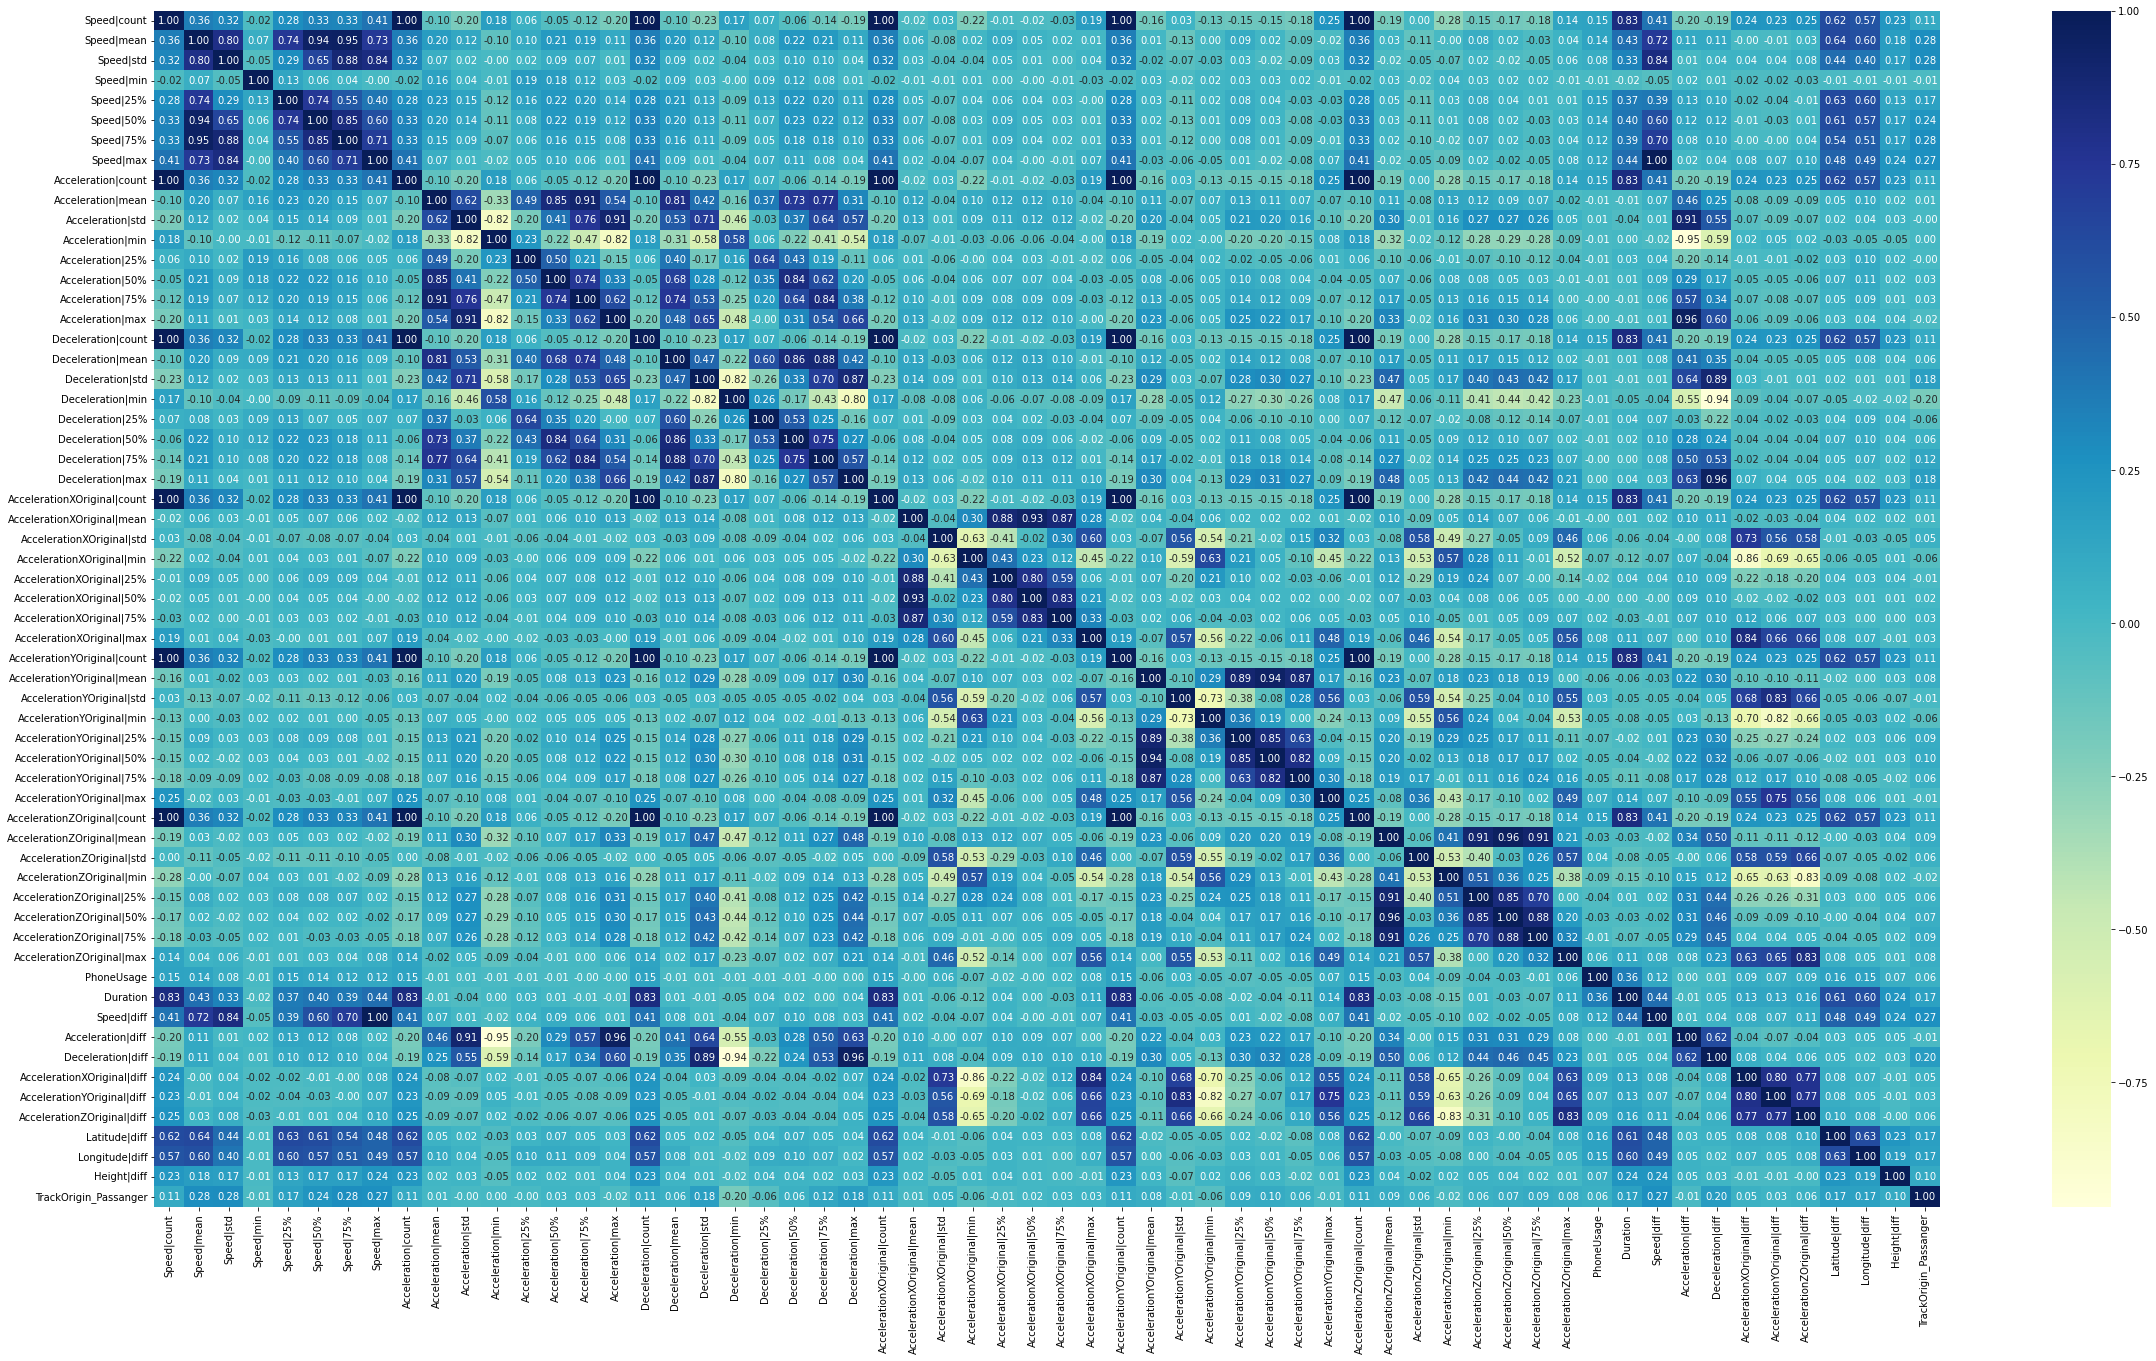

In [ ]:
# Look at the feature correlation
corr = TrackDB.corr()
plt.figure(figsize = (40, 22)) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

In [11]:
# Delete columns with near zero correlation
TrackDB = TrackDB.drop(['Speed|min', 'Acceleration|mean', 'Acceleration|std', 'Acceleration|min',
       'Acceleration|25%', 'Acceleration|50%', 'Acceleration|75%',
       'Acceleration|max', 'AccelerationXOriginal|mean', 'AccelerationXOriginal|25%', 'AccelerationXOriginal|50%',
       'AccelerationXOriginal|75%', 'AccelerationYOriginal|std', 'AccelerationYOriginal|min', 'AccelerationYOriginal|max'], axis=1)

In [12]:
#Prepare data
X = TrackDB.loc[:,TrackDB.columns != 'TrackOrigin_Passanger']
y = TrackDB.loc[:,'TrackOrigin_Passanger']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size=0.2, random_state=1)
y.value_counts(normalize=True)

0.0    0.773096
1.0    0.226904
Name: TrackOrigin_Passanger, dtype: float64

In [13]:
# RandomForestClassifier model train
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
# RandomForestClassifier model prediction
rfc_pred = rfc.predict(X_test)
rfc_pred_proba = rfc.predict_proba(X_test)

print(classification_report(rfc_pred, y_test))
print('ROC-AUC score', roc_auc_score(y_test, rfc_pred_proba[:,1]))
print(confusion_matrix(rfc_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       461
         1.0       0.33      0.68      0.44        57

    accuracy                           0.81       518
   macro avg       0.64      0.76      0.66       518
weighted avg       0.89      0.81      0.84       518

ROC-AUC score 0.7488679682399275
[[381  80]
 [ 18  39]]


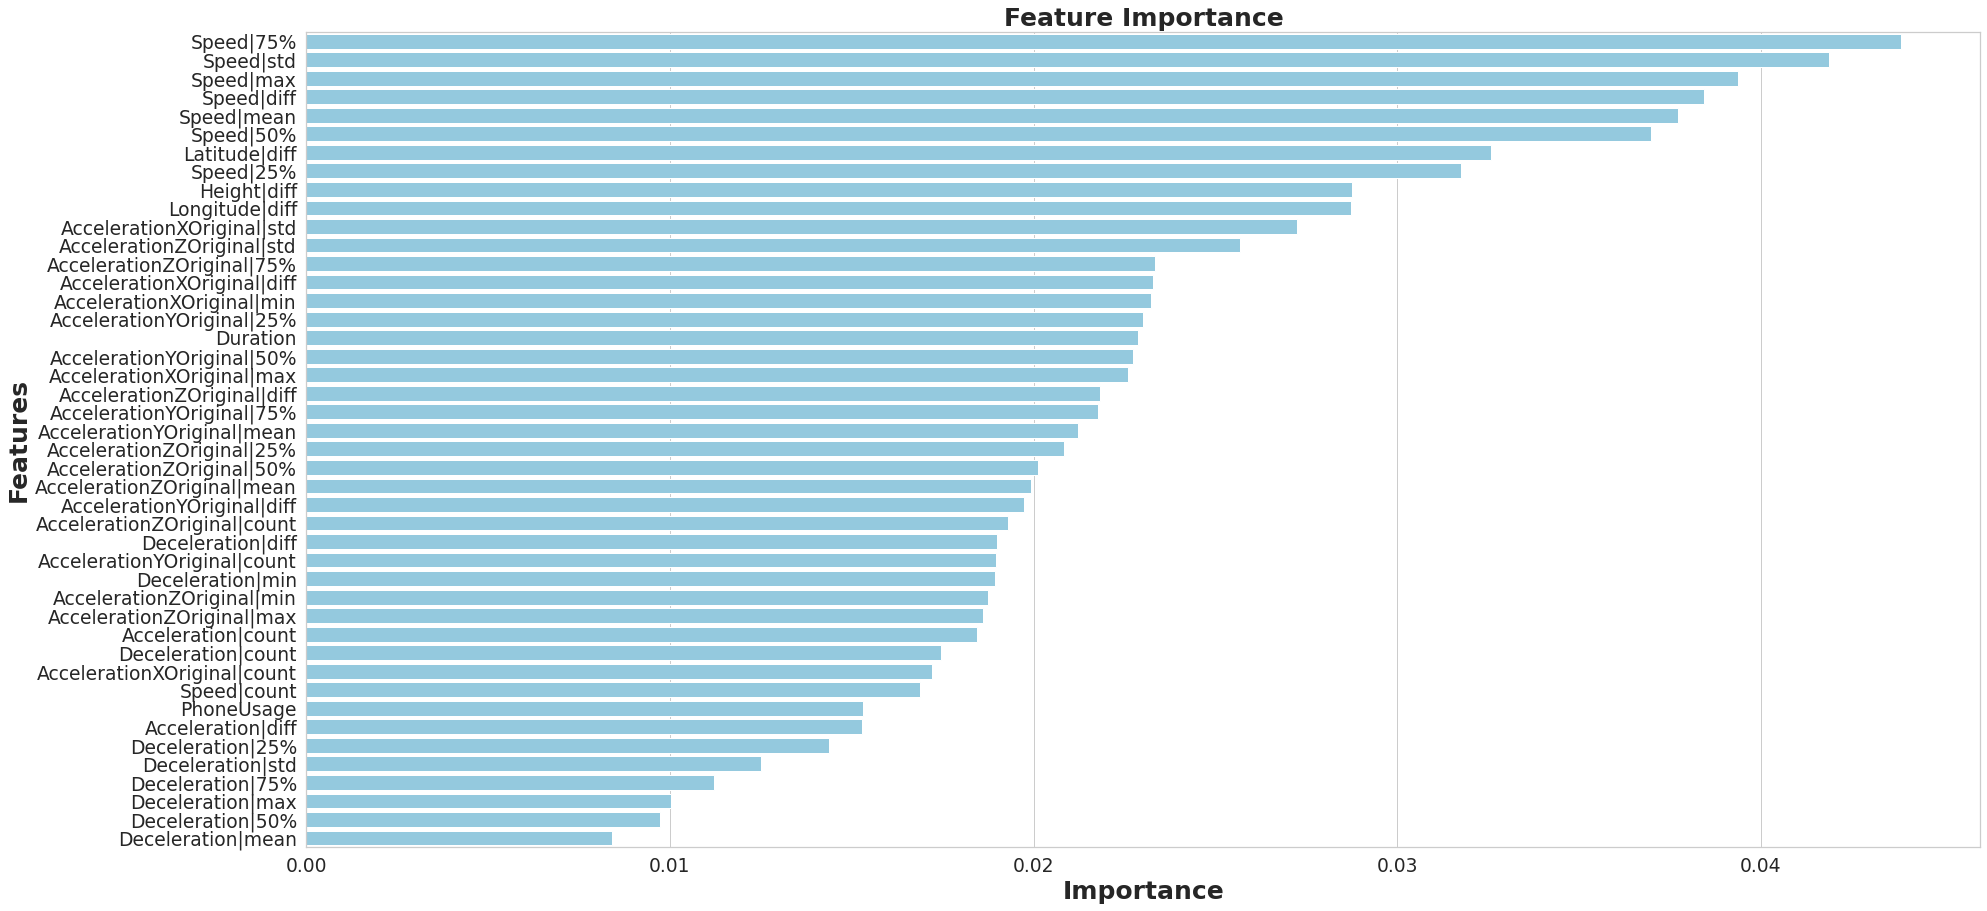

None

In [ ]:
# Plot feature importance bar
feats = {}
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())

In [15]:
# Search parametrs RandomForestClassifier with RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(RandomForestClassifier(), 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'bootstrap': False,
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 683}

In [16]:
# RandomForestClassifier model prediction
RFCs_pred = rs.predict(X_test)
RFCs_pred_proba = rs.predict_proba(X_test)

print(classification_report(RFCs_pred, y_test))
print('ROC-AUC score', roc_auc_score(y_test, RFCs_pred_proba[:,1]))
print(confusion_matrix(RFCs_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       455
         1.0       0.35      0.67      0.46        63

    accuracy                           0.81       518
   macro avg       0.65      0.75      0.67       518
weighted avg       0.88      0.81      0.83       518

ROC-AUC score 0.7571870853604599
[[378  77]
 [ 21  42]]


In [ ]:
# RandomizedSearchCV results table
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,683,12,1,sqrt,13,False,0.811504,1
1,577,23,1,sqrt,15,False,0.808603,2
2,683,23,6,log2,15,False,0.808119,3
3,366,23,1,sqrt,14,False,0.805219,4
4,683,2,1,log2,11,True,0.803774,5
5,683,18,6,sqrt,7,False,0.800869,6
6,577,50,1,sqrt,7,False,0.798456,7
7,366,23,11,sqrt,11,True,0.798456,7
8,1000,12,6,sqrt,10,True,0.798454,9
9,472,23,22,sqrt,8,False,0.798453,10


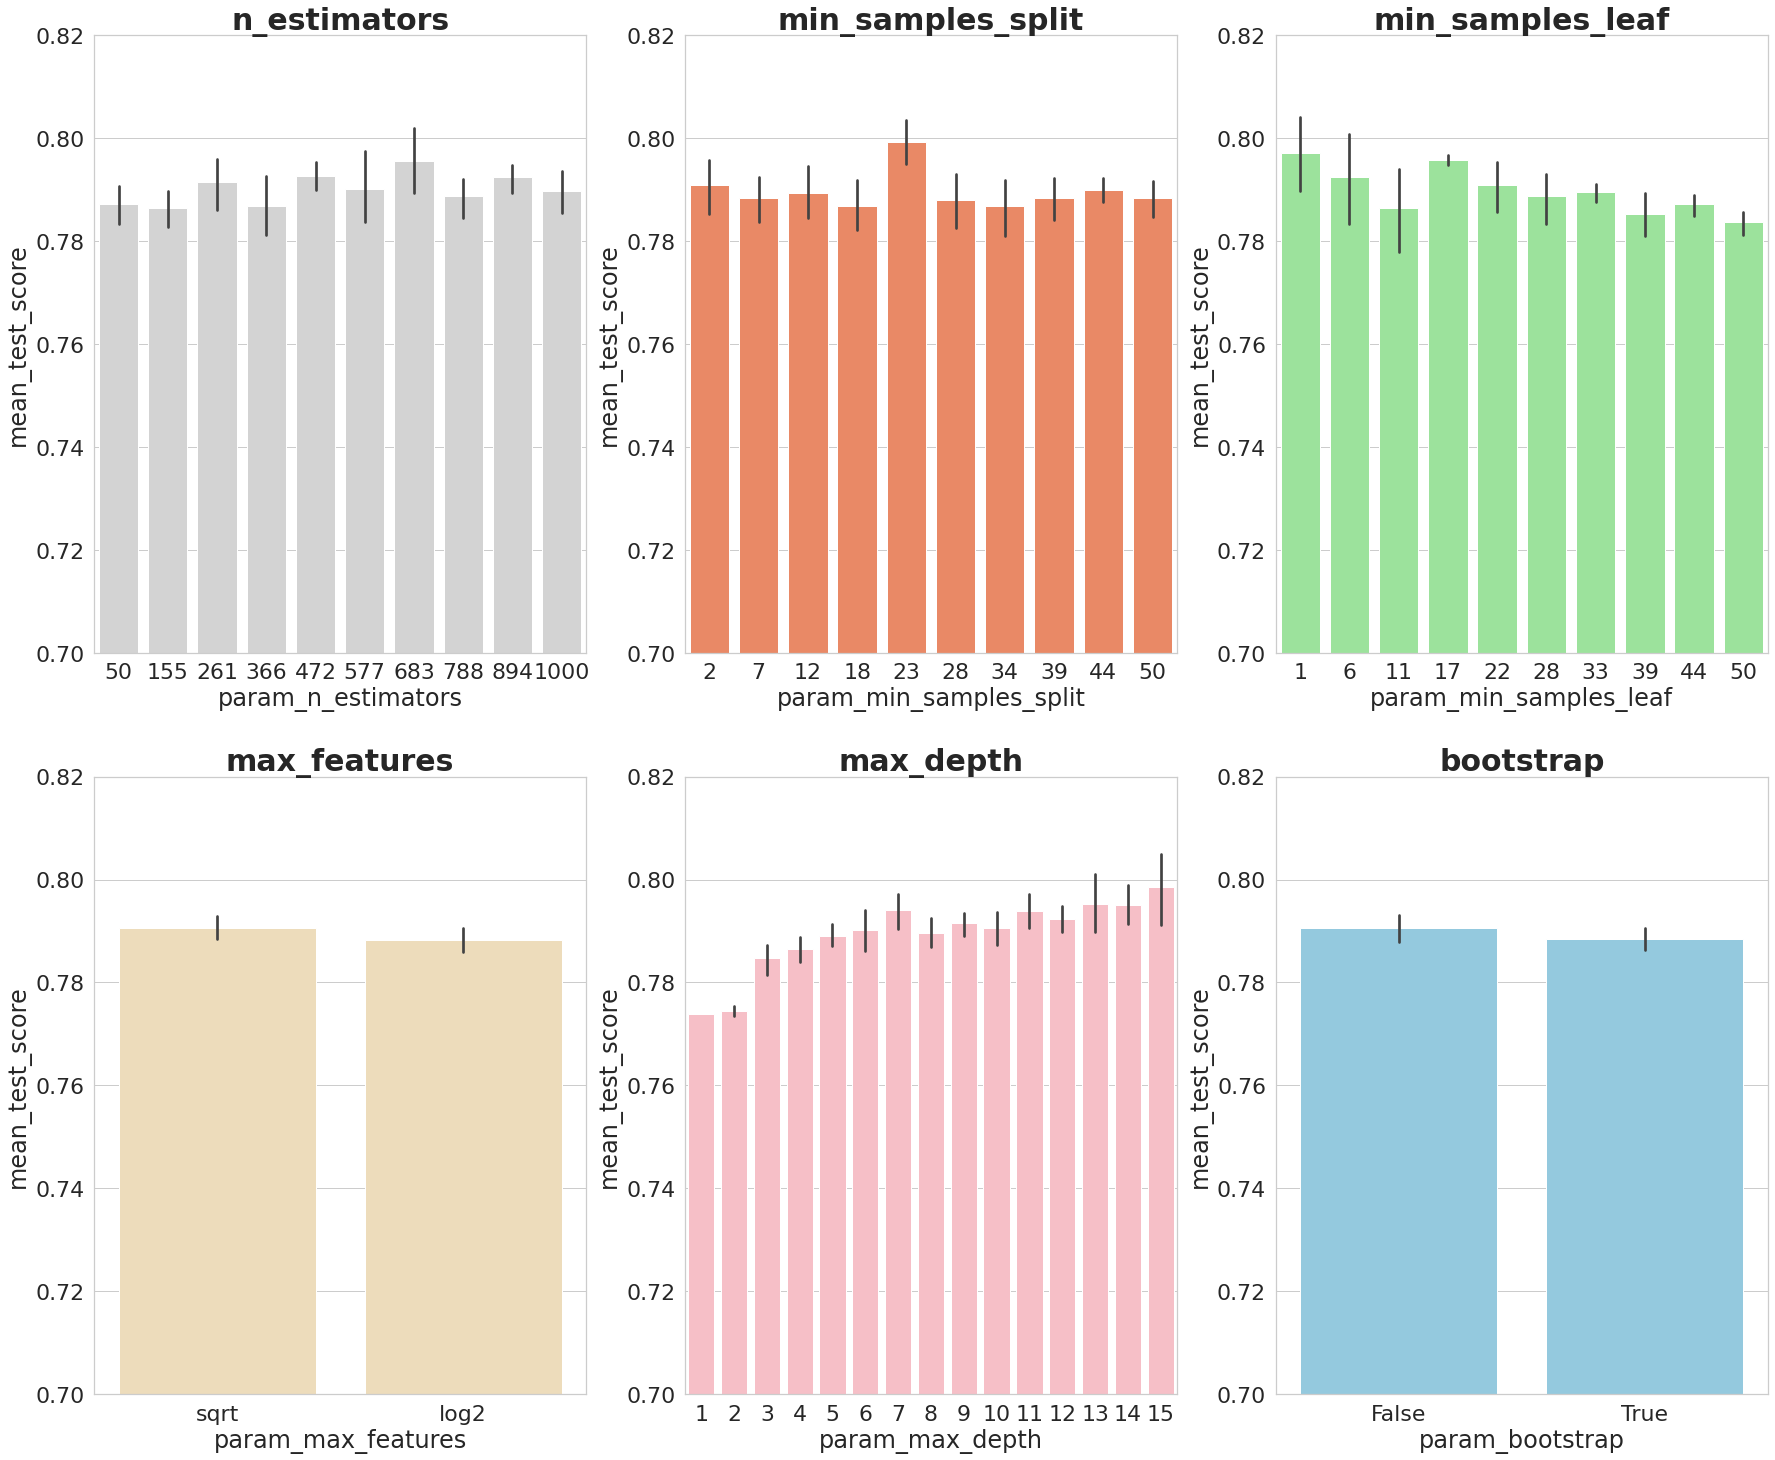

In [ ]:
# RandomizedSearchCV results bars
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.7,.82])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.7,.82])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.7,.82])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.7,.82])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.7,.82])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.7,.82])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [17]:
# Search parametrs RandomForestClassifier with GridSearchCV
n_estimators = [500,600,700]
max_features = ['sqrt']
max_depth = [11,13,15]
min_samples_split = [12,18,23]
min_samples_leaf = [1,6,17]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': False,
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 600}

In [18]:
# RandomForestClassifier model prediction
RFCg_pred = gs.predict(X_test)
RFCg_pred_proba = gs.predict_proba(X_test)

print(classification_report(RFCg_pred, y_test))
print('ROC-AUC score', roc_auc_score(y_test, RFCg_pred_proba[:,1]))
print(confusion_matrix(RFCg_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88       457
         1.0       0.33      0.64      0.43        61

    accuracy                           0.80       518
   macro avg       0.64      0.73      0.66       518
weighted avg       0.87      0.80      0.83       518

ROC-AUC score 0.7576083064804869
[[377  80]
 [ 22  39]]


In [19]:
# ExtraTreesClassifier model train
Eforest = ExtraTreesClassifier(n_estimators=700, n_jobs=-1, random_state=1)
Eforest.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=700, n_jobs=-1, random_state=1)

In [24]:
# ExtraTreesClassifier model prediction
EFC_pred = Eforest.predict(X_test)
EFC_pred_proba = Eforest.predict_proba(X_test)

print(classification_report(EFC_pred, y_test))
print('ROC-AUC score', roc_auc_score(y_test, EFC_pred_proba[:,1]))
print(confusion_matrix(EFC_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       457
         1.0       0.34      0.67      0.46        61

    accuracy                           0.81       518
   macro avg       0.65      0.75      0.67       518
weighted avg       0.88      0.81      0.83       518

ROC-AUC score 0.7713717065773679
[[379  78]
 [ 20  41]]
0.3551484972434643
